In [1]:
import os
from numpy import *
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
plt.style.use("seaborn-darkgrid")
# plt.style.use("dark_background") # dark bg plots
sns.set(style="ticks", context="talk")
# %matplotlib inline
# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# disable nonsensical pandas warning 
pd.options.mode.chained_assignment = None

### Folder Structure

In [3]:
#%% Read in data
root = Path('/home/alal/Dropbox/1_Research/India_Forests/')
code = root / 'Code'
data = root / 'Data'

In [4]:
%cd $data

/c/Users/alal/Dropbox/1_Research/India_Forests/Data


### Ingest Block level shapefile

In [5]:
block = gpd.read_file(data/'Spatial/Vectors/2001/BLOCKMAP.shp')

state = gpd.read_file(data/'Spatial/Vectors/2001/STATE.shp')

In [6]:
block.head()
block.info()

,BLOCK_ID,NAME,DISTRICT,STATE_UT,C_CODE01,TOT_NM_HH,TOT_POP,M_POP,F_POP,TOT_L6,...,U_T_MRG_HH,U_M_MRG_HH,U_F_MRG_HH,U_T_MRG_OT,U_M_MRG_OT,U_F_MRG_OT,U_TOT_NNW,U_M_NNW,U_F_NNW,geometry
0,2,Data Not Available,None,None,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((77.57774 35.39891, 77.57571 35.39656..."
1,3,Durbok,Leh (Ladakh),Jammu & Kashmir,None,951,4675,2418,2257,595,...,0,0,0,0,0,0,0,0,0,"POLYGON ((77.32441 35.20002, 77.33263 35.22842..."
2,4,Nubra,Leh (Ladakh),Jammu & Kashmir,None,3372,17367,8994,8373,2171,...,0,0,0,0,0,0,0,0,0,"POLYGON ((76.41376 34.89877, 76.42271 34.89607..."
3,5,Kargil,Kargil,Jammu & Kashmir,None,6024,40718,24008,16710,5721,...,1,0,1,133,108,25,5897,2877,3020,"POLYGON ((76.41376 34.89877, 76.42316 34.88527..."
4,6,Drass,Kargil,Jammu & Kashmir,None,1650,11662,6153,5509,2224,...,0,0,0,0,0,0,0,0,0,"POLYGON ((75.25462 34.62896, 75.26775 34.63229..."


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6348 entries, 0 to 6347
Columns: 171 entries, BLOCK_ID to geometry
dtypes: geometry(1), int64(166), object(4)
memory usage: 8.3+ MB


In [7]:
states = [a for a in block.STATE_UT.unique() if a is not None]
sort(states)

array(['Andaman & Nicobar', 'Andhra Pradesh', 'Arunachal  Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
       'Dadra & Nagar Haveli', 'Daman & Diu', 'Delhi', 'Goa', 'Gujarat',
       'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand',
       'Karnataka', 'Kerala', 'Lakshdweep', 'Madhya Pradesh',
       'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'Orissa', 'Pondicherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamilnadu', 'Tripura', 'Uttar Pradesh', 'Uttranchal',
       'West Bengal'], dtype='<U20')

In [8]:
state_abrs = dict([
    ('Orissa', 'or'),
    ('Andhra Pradesh', 'ap'),
    ('Jharkhand', 'jk'),
    ('Gujarat', 'gu'),
    ('Maharashtra', 'mh'),
    ('Chhattisgarh', 'ch'),
    ('Madhya Pradesh', 'mp'),
    ('Rajasthan', 'rj'),
    ('Himachal Pradesh', 'hp')
])

sched_area_states = state_abrs.values()

# data prep

In [9]:
block['named'] = block.DISTRICT.str.lower()
block['nameb'] = block.NAME.str.lower()

In [10]:
block['state'] = block.STATE_UT
block["state"].replace(state_abrs, inplace = True)

In [11]:
block['state'].unique()

array([None, 'Jammu & Kashmir', 'hp', 'Punjab', 'Uttranchal', 'Haryana',
       'Chandigarh', 'Uttar Pradesh', 'rj', 'Arunachal  Pradesh', 'Delhi',
       'Sikkim', 'Assam', 'Bihar', 'West Bengal', 'Nagaland', 'mp',
       'Meghalaya', 'Manipur', 'jk', 'gu', 'Mizoram', 'Tripura', 'ch',
       'or', 'mh', 'Daman & Diu', 'ap', 'Karnataka', 'Pondicherry', 'Goa',
       'Tamilnadu', 'Kerala', 'Dadra & Nagar Haveli', 'Lakshdweep',
       'Andaman & Nicobar'], dtype=object)

In [12]:
# initialise values to 0
block['sch'] = 0

# Assign Treatment 

### Function that takes list of districts and (district, block) pairs and modifies dataframe inplace

In [13]:
def sched_labeller(d, st, d_sch, b_sch, d_block_samp=None):
    """
    function to label blocks as scheduled and block_samp based on list 
    of district names and a dict
    """
    df = d.loc[d.state == st] # subset to state
    ############################## 
    # district level classifications
    ############################## 
    # slower but noisier prep
    for dist in d_sch:
        df.loc[df.named == dist, 'sch'] = 1 
        print(f'Changed {df.loc[df.named == dist].shape[0]} obs for district {dist}')
    
    ############################## 
    # Block sample - legacy
    ############################## 
    # if d_block_samp is not None: # if block name 
    #    df.loc[df.named.isin(d_block_samp), 'block_samp'] = 1 
    ############################## 
    # district - block sample
    ############################## 
    districts = df.named.unique() 
    blocks    = df.nameb.unique()
    # iterate through dict of (district, block) pairs and flag sch = 1 for each 
    for i in b_sch:
        d, b = i[0], i[1] # district, block pair
        error_pairs = []
        if not (d in districts and b in blocks):
            error_pairs.append(i)
        df.loc[(df.named == d) & (df.nameb == b),  'sch'] = 1 
        # noisy
        print(f'Changed {df.loc[(df.named == d) & (df.nameb == b)].shape[0]} obs for district = {d}, block = {b}')
    print('---------- MISSING PAIRS ----------')
    print(error_pairs)
    print('------------------------------------')
    return df

### Orissa

* Source: Ministry of Tribal Affairs http://tribal.nic.in/Content/ScheduledAreasinOrissaSSAreas.aspx
https://web.archive.org/web/20170819102032/http://tribal.nic.in:80/Content/ScheduledAreasinOrissaSSAreas.aspx
* History: The Scheduled area in the State of Orissa was originally specified by the Scheduled Areas (Part A States) Order, 1950 (Constitution Order, 9) dated 23.1.1950 and the Scheduled Areas (Part B States) Order, 1950, (Constitution Order, 26) dated 7.12.1950 and has been respecified by the Scheduled Areas (States of Bihar Gujarat, Madhya Pradesh and Orissa) Order, 1977, (Constitution Order, 109) dated 31.12.1977 after rescinding the earlier Orders in so far as they related to the State of Orissa.

In [14]:
sort(block.loc[block.state == "or"].nameb.unique())
block.loc[(block.state == "or") & (block.nameb == 'surada')].named.unique()

array(['aali', 'agalpur', 'ambabhona', 'anandapur-i', 'anugul', 'asika',
       'astaranga', 'athagad', 'athmallik', 'attabira', 'badachana',
       'badamba', 'bahalda', 'bahanaga', 'balangir', 'baleshwar sadar',
       'balianta', 'baliapal', 'baliguda', 'balikuda', 'balipatna',
       'balisankara', 'bamra', 'banapur', 'banarpal', 'bandhugaon',
       'baneigarh', 'bangiriposi', 'bangomunda', 'banki', 'banki-dampara',
       'banspal', 'bant', 'baragaon', 'barang', 'barapali', 'bargarh',
       'bari', 'baripada', 'barkot', 'barsahi', 'basta', 'basudebpur',
       'baudh', 'begunia', 'beguniapada', 'bellaguntha', 'belpara',
       'betanati', 'bhadrak', 'bhandari pokhari', 'bhanjanagar', 'bhapur',
       'bhatli', 'bhawanipatna', 'bheden', 'bhograi', 'bhuban',
       'bhubaneswar', 'bijatola', 'bijepur', 'binika', 'binjharpur',
       'biramaharajpur', 'biridi', 'bishamakatak', 'bisoi', 'bisra',
       'boden', 'boipariguda', 'bolagad', 'boriguma', 'brahmagiri',
       'buguda', 'ch

array(['ganjam'], dtype=object)

In [15]:
# Orissa
or_d_sch = ["mayurbhanj", "sundargarh", "koraput"]

or_b_sch = [("sambalpur", "kochinda"), 
                 ("kendujhar", "kendujhargarh"), # found 
                 ("kendujhar", "telkoi"), 
                 ("kendujhar", "champua"),
                 ("kendujhar", "banspal"), 
                 ("baudh", "kantamal"),
                 ("kandhamal", "g.udayagiri"),  # fixed
                 ("kandhamal", "baliguda"),
                 ("kalahandi", "thuamul-rampur"), # fixed
                 ("kalahandi", "lanjigarh"),
                 ("baleshwar", "nilagiri"), 
                 ("gajapati", "r.udaygiri"), # fixed
                 ("gajapati", "guma"), 
                 ("gajapati", "rayagada"),
                 ("gajapati", "parlakhemundi (gosani)"), # fixed
                 ("ganjam", "surada")]

or2 = sched_labeller(block, 'or', or_d_sch, or_b_sch) #, or_d_block_samp)
or2.sch.value_counts()

Changed 26 obs for district mayurbhanj
Changed 17 obs for district sundargarh
Changed 14 obs for district koraput
Changed 1 obs for district = sambalpur, block = kochinda
Changed 1 obs for district = kendujhar, block = kendujhargarh
Changed 1 obs for district = kendujhar, block = telkoi
Changed 1 obs for district = kendujhar, block = champua
Changed 1 obs for district = kendujhar, block = banspal
Changed 1 obs for district = baudh, block = kantamal
Changed 1 obs for district = kandhamal, block = g.udayagiri
Changed 1 obs for district = kandhamal, block = baliguda
Changed 1 obs for district = kalahandi, block = thuamul-rampur
Changed 1 obs for district = kalahandi, block = lanjigarh
Changed 1 obs for district = baleshwar, block = nilagiri
Changed 1 obs for district = gajapati, block = r.udaygiri
Changed 1 obs for district = gajapati, block = guma
Changed 1 obs for district = gajapati, block = rayagada
Changed 1 obs for district = gajapati, block = parlakhemundi (gosani)
Changed 1 obs fo

0    241
1     73
Name: sch, dtype: int64

### Andhra

https://web.archive.org/web/20170818085914/http://tribal.nic.in/Content/ScheduledAreasinAndhraPradeshSSAreas.aspx

https://pesadarpan.gov.in/en_US/fifth-schedule-areas?p_p_id=122_INSTANCE_kKN0LGcIxmYl&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&p_p_col_id=_118_INSTANCE_NK1DjTMey0mQ__column-1&p_p_col_count=1&p_r_p_564233524_resetCur=true&p_r_p_564233524_categoryId=27580

In [16]:
sort(block.loc[(block.state == "ap")].named.unique())
sort(block.loc[(block.state == "ap")].nameb.unique())

array(['adilabad', 'anantapur', 'chittoor', 'cuddapah', 'east godavari',
       'guntur', 'hyderabad', 'karimnagar', 'khammam', 'krishna',
       'kurnool', 'mahbubnagar', 'medak', 'nalgonda', 'nellore',
       'nizamabad', 'prakasam', 'rangareddi', 'srikakulam',
       'visakhapatnam', 'vizianagaram', 'warangal', 'west godavari'],
      dtype=object)

array(['a.konduru', 'achampet', 'achanta', ..., 'zaffergadh', 'zahirabad',
       'zarugumilli'], dtype=object)

In [17]:
#%% Andhra
ap_d_sch = ["visakhapatnam", "east godavari"]
ap_b_sch = [("adilabad", "adilabad"), ("adilabad", "boath"),
                 ("adilabad", "asifabad"), ("adilabad", "sirpur"),
                 ("adilabad", "luxettipet"), ("warangal", "mulug"),
                 ("warangal", "narsampet"), ("khammam", "palwancha"),
                 ("khammam", "yellandu")]

ap2 = sched_labeller(block, 'ap', ap_d_sch, ap_b_sch) # ap_d_block_samp)
ap2.sch.value_counts()

Changed 43 obs for district visakhapatnam
Changed 59 obs for district east godavari
Changed 1 obs for district = adilabad, block = adilabad
Changed 1 obs for district = adilabad, block = boath
Changed 1 obs for district = adilabad, block = asifabad
Changed 1 obs for district = adilabad, block = sirpur
Changed 1 obs for district = adilabad, block = luxettipet
Changed 1 obs for district = warangal, block = mulug
Changed 1 obs for district = warangal, block = narsampet
Changed 1 obs for district = khammam, block = palwancha
Changed 1 obs for district = khammam, block = yellandu
---------- MISSING PAIRS ----------
[]
------------------------------------


0    999
1    111
Name: sch, dtype: int64

### Jharkhand
https://web.archive.org/web/20170819035933/http://tribal.nic.in/Content/ScheduledAreasinJharkhandSSAreas.aspx

In [18]:
sort(block.loc[(block.state == "jk")].named.unique())
sort(block.loc[(block.state == "jk")].nameb.unique())

array(['bokaro', 'chatra', 'deoghar', 'dhanbad', 'dumka', 'garhwa',
       'giridih', 'godda', 'gumla', 'hazaribag', 'kodarma', 'lohardaga',
       'pakaur', 'palamu', 'pashchimi singhbhum', 'purbi singhbhum',
       'ranchi', 'sahibganj'], dtype=object)

array(['adityapur (gamharia)', 'amrapara', 'angara',
       'baghmara-cum-katras', 'bagodar', 'baharagora', 'baliapur',
       'balumath', 'bandgaon', 'bano', 'barhait', 'barharwa', 'barhi',
       'barkagaon', 'barkatha', 'barwadih', 'basia', 'bengabad', 'bermo',
       'bero', 'bhandaria', 'bhandra', 'bhawnathpur', 'birni',
       'bishrampur', 'bishungarh', 'bishunpur', 'boarijor', 'bolba',
       'borio', 'bundu', 'burmu', 'chaibasa', 'chainpur', 'chakradharpur',
       'chakulia', 'chandankiyari', 'chandil', 'chandwa', 'chanho',
       'chas', 'chatra', 'chauparan', 'chhatarpur', 'chinia', 'churchu',
       'daltonganj', 'dandai', 'deoghar', 'deori', 'devipur',
       'dhalbhumgarh', 'dhanbad-cum-kenduadih-cum-jagta', 'dhanwar',
       'dhurki', 'dumaria', 'dumka', 'dumri', 'erki (tamar ii)', 'gande',
       'garhwa', 'garu', 'gawan', 'ghaghra', 'ghatshila', 'gidhaur',
       'giridih', 'gobindpur', 'gobindpur (rajnagar)', 'godda',
       'goilkera', 'gola', 'golmuri-cum-jugsalai'

In [19]:
#%% Jharkhand
jk_d_sch = [
    "ranchi", "lohardaga", "gumla", "purbi singhbhum", "pashchimi singhbhum",
    "sahibganj", "pakaur", "dumka"
]
jk_b_sch = [("gumla", "simdega"), ("palamu", "latehar"),
                 ("palamu", "satbarwa"), ("godda", "sundarpahari"),
                 ("godda", "boarijor"), ("dumka", "jamtara"),
                 ("garhwa", "bhandaria")]

jk2 = sched_labeller(block, 'jk', jk_d_sch, jk_b_sch) #, jk_d_block_samp)
jk2.sch.value_counts()

Changed 20 obs for district ranchi
Changed 5 obs for district lohardaga
Changed 18 obs for district gumla
Changed 9 obs for district purbi singhbhum
Changed 23 obs for district pashchimi singhbhum
Changed 9 obs for district sahibganj
Changed 6 obs for district pakaur
Changed 14 obs for district dumka
Changed 1 obs for district = gumla, block = simdega
Changed 1 obs for district = palamu, block = latehar
Changed 1 obs for district = palamu, block = satbarwa
Changed 1 obs for district = godda, block = sundarpahari
Changed 1 obs for district = godda, block = boarijor
Changed 1 obs for district = dumka, block = jamtara
Changed 1 obs for district = garhwa, block = bhandaria
---------- MISSING PAIRS ----------
[]
------------------------------------


1    109
0    101
Name: sch, dtype: int64

### Gujarat

https://web.archive.org/web/20170819103039/http://tribal.nic.in/Content/ScheduledAreasinGujarat.aspx
https://pesadarpan.gov.in/web/guest/hidden/-/asset_publisher/PSDIGLsdo3bO/content/scheduled-areas-in-gujarat/26993?redirect=https://pesadarpan.gov.in/fifth-schedule-areas?p_p_id=122_INSTANCE_kKN0LGcIxmYl&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&p_p_col_id=_118_INSTANCE_NK1DjTMey0mQ__column-1&p_p_col_count=1&p_r_p_564233524_resetCur=true&p_r_p_564233524_categoryId=27020&entry_id=41141&show_back=true

In [20]:
sort(block.loc[(block.state == "gu")].named.unique())
sort(block.loc[(block.state == "gu")].nameb.unique())

array(['ahmadabad', 'amreli', 'anand', 'banas kantha', 'bharuch',
       'bhavnagar', 'dohad', 'gandhinagar', 'jamnagar', 'junagadh',
       'kachchh', 'kheda', 'mahesana', 'narmada', 'navsari',
       'panch mahals', 'patan', 'porbandar', 'rajkot', 'sabar kantha',
       'surat', 'surendranagar', 'the dangs', 'vadodara', 'valsad'],
      dtype=object)

array(['abdasa', 'ahmadabad city', 'amirgadh', 'amod', 'amreli', 'anand',
       'anjar', 'anklav', 'anklesvar', 'babra', 'bagasara', 'balasinor',
       'bansda', 'bardoli', 'barwala', 'bavla', 'bayad', 'becharaji',
       'bhabhar', 'bhachau', 'bhanvad', 'bharuch', 'bhavnagar', 'bhesan',
       'bhiloda', 'bhuj', 'borsad', 'botad', 'chanasma', 'chhota udaipur',
       'chikhli', 'chorasi', 'chotila', 'chuda', 'dabhoi', 'danta',
       'dantiwada', 'dasada', 'daskroi', 'dediapada', 'deesa', 'dehgam',
       'deodar', 'detroj-rampura', 'devgadbaria', 'dhandhuka', 'dhanera',
       'dhanpur', 'dhansura', 'dharampur', 'dhari', 'dholka', 'dhoraji',
       'dhrangadhra', 'dhrol', 'dohad', 'fatepura', 'gadhada', 'gandevi',
       'gandhidham', 'gandhinagar', 'garbada', 'gariadhar', 'ghogha',
       'ghoghamba', 'godhra', 'gondal', 'halol', 'halvad', 'hansot',
       'harij', 'himatnagar', 'idar', 'jafrabad', 'jalalpore',
       'jambughoda', 'jambusar', 'jamjodhpur', 'jamkandorna', 'jamnaga

In [21]:
#%%# Gujarat
gu_d_sch = []

gu_b_sch = [
       ("the dangs", "the dangs"),  # fixed, sep the dangs
       ("bharuch", "jhagadia"), 
       ("bharuch", "valia"), 
       ("dohad", "devgadbaria"), 
       ("dohad", "dohad"), 
       ("dohad", "jhalod"), 
       ("dohad", "limkheda"), 
    ("dohad", "devgadbaria"), 
       ("narmada", "dediapada"), 
       ("narmada", "nandod"), 
       ("narmada", "sagbara"), 
       ("panch mahals", "santrampur"), 
       ("surat", "uchchhal"), 
       ("surat", "vyara"), 
       ("surat", "mahuva"), 
       ("surat", "mandvi"),
       ("surat", "nizar"),
       ("surat", "mangrol"), 
       ("surat", "songadh"),
       ("surat", "valod"),
       ("surat", "bardoli"),    
       ("vadodara", "chhota udaipur"), 
       ("vadodara", "nasvadi"), 
       ("valsad", "dharampur"), 
       ("valsad", "pardi"), 
       ("valsad", "umbergaon"),
       ("navsari", "bansda"),
       ("navsari", "chikhli") 
       
]


gu2 = sched_labeller(block, 'gu', gu_d_sch, gu_b_sch)
gu2.sch.value_counts()

Changed 1 obs for district = the dangs, block = the dangs
Changed 1 obs for district = bharuch, block = jhagadia
Changed 1 obs for district = bharuch, block = valia
Changed 1 obs for district = dohad, block = devgadbaria
Changed 1 obs for district = dohad, block = dohad
Changed 1 obs for district = dohad, block = jhalod
Changed 1 obs for district = dohad, block = limkheda
Changed 1 obs for district = dohad, block = devgadbaria
Changed 1 obs for district = narmada, block = dediapada
Changed 1 obs for district = narmada, block = nandod
Changed 1 obs for district = narmada, block = sagbara
Changed 1 obs for district = panch mahals, block = santrampur
Changed 1 obs for district = surat, block = uchchhal
Changed 1 obs for district = surat, block = vyara
Changed 1 obs for district = surat, block = mahuva
Changed 1 obs for district = surat, block = mandvi
Changed 1 obs for district = surat, block = nizar
Changed 1 obs for district = surat, block = mangrol
Changed 1 obs for district = surat, b

0    200
1     27
Name: sch, dtype: int64

### Maharashtra

https://web.archive.org/web/20170818101527/http://tribal.nic.in/Content/ScheduledAreasinMaharashtraSSAreas.aspx

In [23]:
#%%# Maharashtra
mh_d_sch = []

mh_b_sch =  [("thane", "palghar"), ("thane", "vasai"), 
             ("thane", "bhiwandi"), ("thane", "murbad"), 
             ("nashik", "dindori"), ("nashik", "igatpuri"),
     ("nashik", "nashik"), ("nashik", "baglan"), ("dhule", "sakri"),
     ("dhule", "shirpur"), ("nandurbar", "nandurbar"),
     ("nandurbar", "shahade"), ("jalgaon", "chopda"), ("jalgaon", "raver"),
     ("jalgaon", "yawal"), ("pune", "ambegaon"), ("pune", "junnar"),
     ("nanded", "kinwat"), ("yavatmal", "maregaon"), ("yavatmal", "ralegaon"),
     ("yavatmal", "kelapur"), ("yavatmal", "ghatanji"),
     ("gadchiroli", "gadchiroli"), ("gadchiroli", "armori"),
     ("gadchiroli", "chamorshi"), ("chandrapur", "rajura"),
     ("ahmadnagar", "akola")]
mh2 = sched_labeller(block, 'mh', mh_d_sch, mh_b_sch)
mh2.sch.value_counts()

Changed 1 obs for district = thane, block = palghar
Changed 1 obs for district = thane, block = vasai
Changed 1 obs for district = thane, block = bhiwandi
Changed 1 obs for district = thane, block = murbad
Changed 1 obs for district = nashik, block = dindori
Changed 1 obs for district = nashik, block = igatpuri
Changed 1 obs for district = nashik, block = nashik
Changed 1 obs for district = nashik, block = baglan
Changed 1 obs for district = dhule, block = sakri
Changed 1 obs for district = dhule, block = shirpur
Changed 1 obs for district = nandurbar, block = nandurbar
Changed 1 obs for district = nandurbar, block = shahade
Changed 1 obs for district = jalgaon, block = chopda
Changed 1 obs for district = jalgaon, block = raver
Changed 1 obs for district = jalgaon, block = yawal
Changed 1 obs for district = pune, block = ambegaon
Changed 1 obs for district = pune, block = junnar
Changed 1 obs for district = nanded, block = kinwat
Changed 1 obs for district = yavatmal, block = maregaon


0    328
1     27
Name: sch, dtype: int64

### Chhatisgarh

https://web.archive.org/web/20170818065659/http://tribal.nic.in/Content/ScheduledAreasinChhattisgarh.aspx


In [24]:
sort(block.query("state == 'ch'").named.unique())
sort(block.query("state == 'ch'").nameb.unique())

array(['bastar', 'bilaspur', 'dantewada', 'dhamtari', 'durg',
       'janjgir - champa', 'jashpur', 'kanker', 'kawardha', 'korba',
       'koriya', 'mahasamund', 'raigarh', 'raipur', 'rajnandgaon',
       'surguja'], dtype=object)

array(['abhanpur', 'abhujhmad (orchha) part', 'akaltara', 'ambikapur',
       'antagarh', 'baderajpur', 'bagbahara', 'bagicha', 'baikunthpur',
       'bakaband', 'baloda', 'balodabazar', 'balrampur',
       'bamhnidih(champa)', 'basna', 'bastanar(bade kilepal)', 'bastar',
       'batauli', 'bemetra', 'berla', 'bhairamgarh', 'bhaiyathan',
       'bhanupratappur', 'bharatpur(janakpur)', 'bhatapara',
       'bhopalpattanam', 'bijapur', 'bilaigarh', 'bilha', 'bodla',
       'chandkhurai(arang)', 'charama', 'chhindgarh', 'chhuikhadan',
       'chhura', 'chhuria', 'chowki', 'dabhra', 'dantewada', 'darbha',
       'deobhog', 'dhamdha', 'dhamtari', 'dharamjaigarh', 'dondi',
       'dondiluhara', 'dongargarh', 'duldula', 'durg', 'durgkondal',
       'gariaband', 'gaurella no.1', 'gaurella no.2', 'geedam',
       'gharghoda', 'gunderdehi', 'gurur', 'jagdalpur', 'jaijaipur',
       'jashpurnagar', 'kanker', 'kansabel', 'kartala', 'kasdol',
       'katekalyan', 'katghora', 'kawardha', 'keshkal', '

In [25]:
#%%# Chhatisgarh
ch_d_sch = ['bastar', 'koriya', 'surguja', 'kanker', 'dantewada',
           'korba', 'jashpur']

ch_b_sch = [("jashpur", "jashpurnagar"), 
            ("raigarh", "kharsia"), 
            ("bilaspur", "kota"), 
            ("bilaspur", "gaurella no.1"), 
            ("bilaspur", "gaurella no.2"), 
            ("bilaspur", "marwahi"), 
            ("korba", "katghora"), 
            ("durg", "dondi"), 
            ("rajnandgaon", "chowki"), 
            ("rajnandgaon", "mohla"), 
            ("rajnandgaon", "manpur"), 
            ("raipur", "mainpur"), 
            ("raipur", "chhura"), 
            ("raipur", "gariaband"), 
            ("dhamtari", "sihwa(nagri)")]

ch2 = sched_labeller(block, 'ch', ch_d_sch, ch_b_sch)
ch2.sch.value_counts()

Changed 14 obs for district bastar
Changed 5 obs for district koriya
Changed 19 obs for district surguja
Changed 7 obs for district kanker
Changed 11 obs for district dantewada
Changed 5 obs for district korba
Changed 8 obs for district jashpur
Changed 1 obs for district = jashpur, block = jashpurnagar
Changed 1 obs for district = raigarh, block = kharsia
Changed 1 obs for district = bilaspur, block = kota
Changed 1 obs for district = bilaspur, block = gaurella no.1
Changed 1 obs for district = bilaspur, block = gaurella no.2
Changed 1 obs for district = bilaspur, block = marwahi
Changed 1 obs for district = korba, block = katghora
Changed 1 obs for district = durg, block = dondi
Changed 1 obs for district = rajnandgaon, block = chowki
Changed 1 obs for district = rajnandgaon, block = mohla
Changed 1 obs for district = rajnandgaon, block = manpur
Changed 1 obs for district = raipur, block = mainpur
Changed 1 obs for district = raipur, block = chhura
Changed 1 obs for district = raipur,

1    82
0    63
Name: sch, dtype: int64

### Madhya Pradesh

https://pesadarpan.gov.in/web/guest/hidden/-/asset_publisher/PSDIGLsdo3bO/content/scheduled-areas-in-madhya-pradesh/26993?redirect=https://pesadarpan.gov.in/fifth-schedule-areas?p_p_id=122_INSTANCE_kKN0LGcIxmYl&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&p_p_col_id=_118_INSTANCE_NK1DjTMey0mQ__column-1&p_p_col_count=1&p_r_p_564233524_resetCur=true&p_r_p_564233524_categoryId=27580&entry_id=41171&show_back=true

In [26]:
sort(block.query("state == 'mp'").named.unique())
sort(block.query("state == 'mp'").nameb.unique())

array(['balaghat', 'barwani', 'betul', 'bhind', 'bhopal', 'chhatarpur',
       'chhindwara', 'damoh', 'datia', 'dewas', 'dhar', 'dindori',
       'east nimar', 'guna', 'gwalior', 'harda', 'hoshangabad', 'indore',
       'jabalpur', 'jhabua', 'katni', 'mandla', 'mandsaur', 'morena',
       'narsimhapur', 'neemuch', 'panna', 'raisen', 'rajgarh', 'ratlam',
       'rewa', 'sagar', 'satna', 'sehore', 'seoni', 'shahdol', 'shajapur',
       'sheopur', 'shivpuri', 'sidhi', 'tikamgarh', 'ujjain', 'umaria',
       'vidisha', 'west nimar'], dtype=object)

array(['agar', 'ajaigarh', 'alirajpur', 'alot', 'amarpatan', 'amarpur',
       'amarwara', 'ambah', 'amla', 'anuppur', 'aron', 'ashoknagar',
       'ashta', 'ater', 'athner', 'babai', 'babai (chichli)',
       'badamalhera', 'badarwas', 'badnagar', 'badnawar', 'badod',
       'badwara', 'bagh', 'bagli', 'bahoriband', 'baidhan', 'baihar',
       'bajang', 'bajna', 'balaghat', 'baldeogarh', 'baldi', 'bamori',
       'banda', 'bankaner (umarvan)', 'bankhedi', 'bareli(badi)',
       'barghat', 'barigarh (batiagarh)', 'barwaha', 'barwani', 'basoda',
       'begamganj', 'beohari', 'berasia', 'betul', 'bhagwanpura',
       'bhainshdehi', 'bhander', 'bhanpura', 'bhavra', 'bhikangaon',
       'bhimpura', 'bhind', 'bhitarwar', 'biaora', 'bichhiya', 'bichhua',
       'bijadandi', 'bijawar', 'bina', 'birsa', 'budni', 'burhanpur',
       'burhar', 'buxwaha', 'chachaura', 'chanderi', 'chaurai',
       'chawarpatha', 'chhapara', 'chhatarpur', 'chhegaon makhan',
       'chhindwara', 'chicholi', 'chitr

In [27]:
#%%# Madhya Pradesh
mp_d_sch = ['jhabua', 'mandla']

mp_b_sch = [("shahdol", "pushparajgarh"),
            ("shahdol", "sohagpur"),
            ("shahdol", "jaisinghnagar"), 
            ("dhar", "sardarpur"), 
            ("dhar", "dhar"), 
            ("dhar", "manawar"), 
            ("dhar", "kukshi"), 
            ("barwani", "barwani"), 
            ("barwani", "rajpur"), 
            ("barwani", "sendhwa"), 
            ("west nimar", "bhikangaon"), 
            ("west nimar", "maheshwar"), 
            ("east nimar", "khalwa"), 
            ("east nimar", "khaknar"), 
            ("ratlam", "sailana"), 
            ("betul", "betul"), 
            ("betul", "bhainshdehi"), 
            ("seoni", "kurai"), 
            ("seoni", "lakhnadon"), 
            ("balaghat", "baihar"), 
            ("hoshangabad", "kesala"), 
            ("sidhi", "kusmi"), 
            ("sheopur", "karahal"), 
            ("chhindwara", "tamia"), 
            ("chhindwara", "jamai(junnardeo)"), 
            ("chhindwara", "harrai"), 
            ("chhindwara", "bichhua")]

mp2 = sched_labeller(block, 'mp', mp_d_sch, mp_b_sch)
mp2.sch.value_counts()

Changed 12 obs for district jhabua
Changed 9 obs for district mandla
Changed 1 obs for district = shahdol, block = pushparajgarh
Changed 1 obs for district = shahdol, block = sohagpur
Changed 1 obs for district = shahdol, block = jaisinghnagar
Changed 1 obs for district = dhar, block = sardarpur
Changed 1 obs for district = dhar, block = dhar
Changed 1 obs for district = dhar, block = manawar
Changed 1 obs for district = dhar, block = kukshi
Changed 1 obs for district = barwani, block = barwani
Changed 1 obs for district = barwani, block = rajpur
Changed 1 obs for district = barwani, block = sendhwa
Changed 1 obs for district = west nimar, block = bhikangaon
Changed 1 obs for district = west nimar, block = maheshwar
Changed 1 obs for district = east nimar, block = khalwa
Changed 1 obs for district = east nimar, block = khaknar
Changed 1 obs for district = ratlam, block = sailana
Changed 1 obs for district = betul, block = betul
Changed 1 obs for district = betul, block = bhainshdehi
Ch

0    265
1     48
Name: sch, dtype: int64

### Rajasthan

https://web.archive.org/web/20170910234200/http://tribal.nic.in:80/Content/ScheduledAreasinRajasthanSSAreas.aspx

https://pesadarpan.gov.in/hidden/-/asset_publisher/PSDIGLsdo3bO/content/scheduled-areas-in-rajasthan/26993?p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&p_p_col_id=column-2&p_p_col_count=1&p_r_p_564233524_resetCur=true&p_r_p_564233524_categoryId=27581&entry_id=41201&show_back=true

In [28]:
sort(block.query("state == 'rj'").named.unique())
sort(block.query("state == 'rj'").nameb.unique())

array(['ajmer', 'alwar', 'banswara', 'baran', 'barmer', 'bharatpur',
       'bhilwara', 'bikaner', 'bundi', 'chittaurgarh', 'churu', 'dausa',
       'dhaulpur', 'dungarpur', 'ganganagar', 'hanumangarh', 'jaipur',
       'jaisalmer', 'jalor', 'jhalawar', 'jhunjhunun', 'jodhpur',
       'karauli', 'kota', 'nagaur', 'pali', 'rajsamand', 'sawai madhopur',
       'sikar', 'sirohi', 'tonk', 'udaipur'], dtype=object)

array(['abu road', 'ahore', 'alsisar', 'amber', 'amet', 'anandpuri',
       'antah', 'anupgarh', 'arain', 'arnod', 'asind', 'aspur', 'atru',
       'bagidora', 'bakani', 'balesar', 'bali', 'balotra', 'bamanwas',
       'bandikui', 'banera', 'bansur', 'banswara', 'bap', 'baran',
       'bargaon', 'bari', 'bari sadri', 'barmer', 'baseri', 'bassi',
       'bayana', 'baytoo', 'begun', 'behror', 'bhadesar', 'bhadra',
       'bhainsrorgarh', 'bhim', 'bhinay', 'bhinder', 'bhinmal',
       'bhopalgarh', 'bhopalsagar', 'bichhiwara', 'bikaner', 'bilara',
       'bonli', 'buhana', 'chaksu', 'chhabra', 'chhipabarod',
       'chhoti sadri', 'chirawa', 'chittaurgarh', 'chohtan', 'churu',
       'dag', 'danta ramgarh', 'dausa', 'deeg', 'degana', 'deogarh',
       'deoli', 'desuri', 'dhariawad', 'dhaulpur', 'dhond', 'dhorimanna',
       'didwana', 'dudu', 'dungargarh', 'dungarpur', 'dungla', 'fatehpur',
       'ganganagar', 'gangapur', 'gangrar', 'garhi', 'ghatol', 'girwa',
       'gogunda', 'govindga

In [29]:
#%%# Rajasthan
rj_d_sch = ['banswara', 'dungarpur']

rj_b_sch = [("udaipur", "girwa")]
#             ("udaipur", "bujdha"),
#             ("udaipur", "dodavli"), 
#             ("udaipur", "alsigdh"),
#             ("udaipur", "pduna"), 
#             ("udaipur", "chawand"),
#             ("udaipur", "saru"), 
#             ("udaipur", "tidi"), 
#             ("udaipur", "jawas"),
#             ("udaipur", "barapal"), 
#             ("udaipur", "titrdi"),
#             ("udaipur", "wati"), 
#             ("udaipur", "chansada"),
#             ("udaipur", "javad"), 
#             ("udaipur", "dantisr"),
#             ("udaipur", "lkdwas")]
rj2 = sched_labeller(block, 'rj', rj_d_sch, rj_b_sch)
rj2.sch.value_counts()

Changed 8 obs for district banswara
Changed 5 obs for district dungarpur
Changed 1 obs for district = udaipur, block = girwa
---------- MISSING PAIRS ----------
[]
------------------------------------


0    223
1     14
Name: sch, dtype: int64

### Himachal Pradesh

https://pesadarpan.gov.in/web/guest/hidden/-/asset_publisher/PSDIGLsdo3bO/content/scheduled-areas-in-himachal-pradesh/26993?redirect=https://pesadarpan.gov.in/fifth-schedule-areas?p_p_id=122_INSTANCE_kKN0LGcIxmYl&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&p_p_col_id=_118_INSTANCE_NK1DjTMey0mQ__column-1&p_p_col_count=1&p_r_p_564233524_resetCur=true&p_r_p_564233524_categoryId=27022&entry_id=41151&show_back=true


In [30]:
sort(block.query("state == 'hp'").named.unique())
sort(block.query("state == 'hp'").nameb.unique())

array(['bilaspur', 'chamba', 'hamirpur', 'kangra', 'kinnaur', 'kullu',
       'lahul and spiti', 'mandi', 'shimla', 'sirmapur', 'solan', 'una'],
      dtype=object)

array(['amb', 'ani', 'baijnath', 'banjar', 'basantpur', 'bhattiyat',
       'bhawarna', 'bhoranj', 'bijhri', 'bilaspur sadar', 'brahmaur',
       'chachyot', 'chamba', 'chauhra', 'chauntra', 'chaupal', 'dera',
       'dharmpur', 'dhundla', 'drang', 'fatehpur', 'gagret', 'geharwin',
       'ghumarwin', 'gopalpur', 'hamirpur', 'indora', 'jubbal kotkhai',
       'kalpa', 'kandaghat', 'kangra', 'karsog', 'kullu', 'kunihar',
       'lahul', 'lambagraon', 'mandi sadar', 'mashobra', 'mehla',
       'nadaun', 'nagar', 'nagrota bagwan', 'nagrota surian', 'nahan',
       'nalagarh', 'narkanda', 'nermand', 'nichar', 'nurpur', 'pachhad',
       'panchrukhi', 'pangi', 'paonta sahib', 'poo', 'pragpur', 'rait',
       'rajgarh', 'rampur', 'rewalsar', 'rohru', 'saluni', 'sangrah',
       'seraj', 'shalai', 'solan', 'spiti', 'sundarnagar', 'theog',
       'tira sujanpur', 'tisa', 'una'], dtype=object)

In [31]:
#%%# Himanchal Pradesh
hp_d_sch = ['lahul and spiti', 'kinnaur']
hp_b_sch = [('chamba', 'pangi'), ('chamba', 'brahmaur')]

hp2 = sched_labeller(block, 'hp', hp_d_sch, hp_b_sch)
hp2.sch.value_counts()

Changed 2 obs for district lahul and spiti
Changed 3 obs for district kinnaur
Changed 1 obs for district = chamba, block = pangi
Changed 1 obs for district = chamba, block = brahmaur
---------- MISSING PAIRS ----------
[]
------------------------------------


0    65
1     7
Name: sch, dtype: int64

## Write file

In [33]:
block2 = pd.concat(
    [or2, ap2, jk2, gu2, ch2, mp2, mh2, hp2, rj2]
    )

In [46]:
block2.to_file(data/"Spatial/Processed/BLOCKS_sch_coded.geojson", 
              'GeoJSON')

# Plot Treatment

(68.11009, 87.91343)

(12.62309, 33.22191)

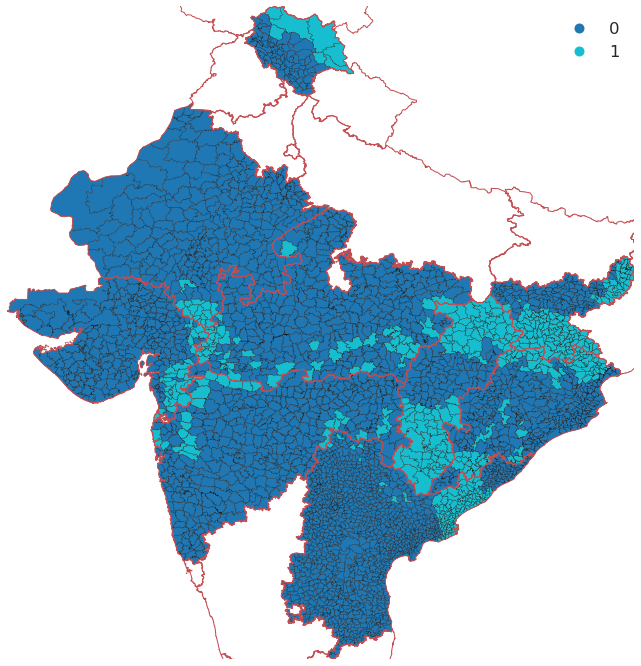

In [34]:
xmin, ymin, xmax, ymax= block2.total_bounds
f, ax = plt.subplots(1, figsize=(12,12))
block2.plot(column='sch', categorical=True, legend=True,
            edgecolor='k',linewidth=0.3,ax=ax)
state.plot(facecolor = 'none', categorical=True, legend=True,
            edgecolor='r',linewidth=1,ax=ax)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_axis_off()

In [35]:
def plot_treatment(statename, colname='sch'):
    """
    Function to slice geodataframe and plot treatment by state
    """
    df = block2.query('state == "{0}"'.format(statename))
    f, ax = plt.subplots(1, figsize=(9,9))
    df.plot(column=colname, categorical=True, legend=True, 
            cmap = 'viridis', ax=ax)
    plt.suptitle('treatment:{0} ; state:{1}'.format(colname, statename),color='r')
    ax.set_axis_off()

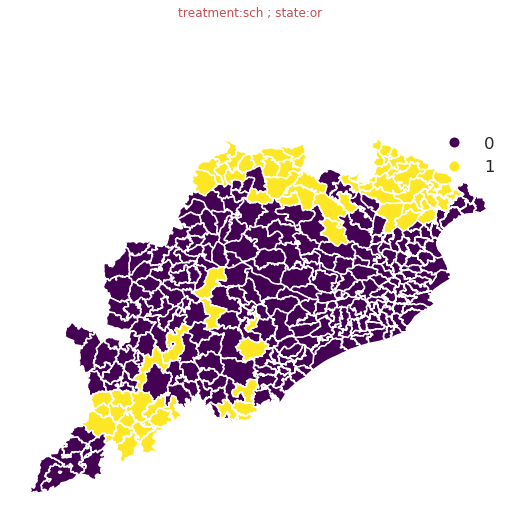

In [36]:
plot_treatment('or')

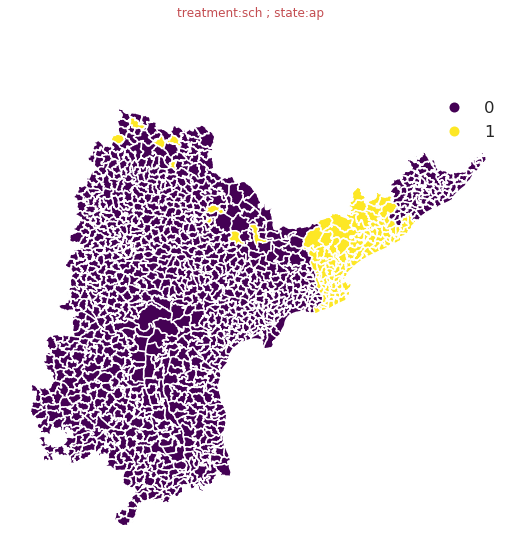

In [37]:
plot_treatment('ap')

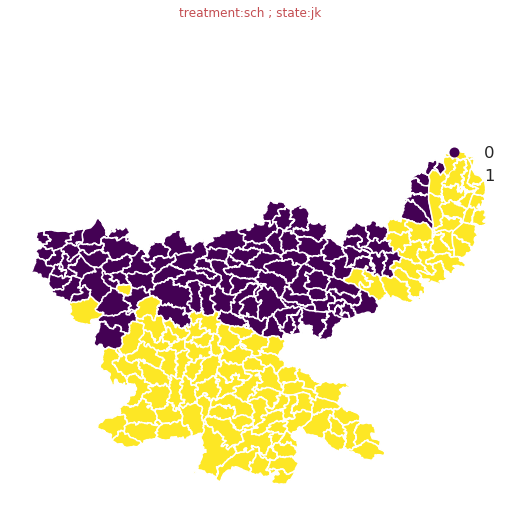

In [38]:
plot_treatment('jk')

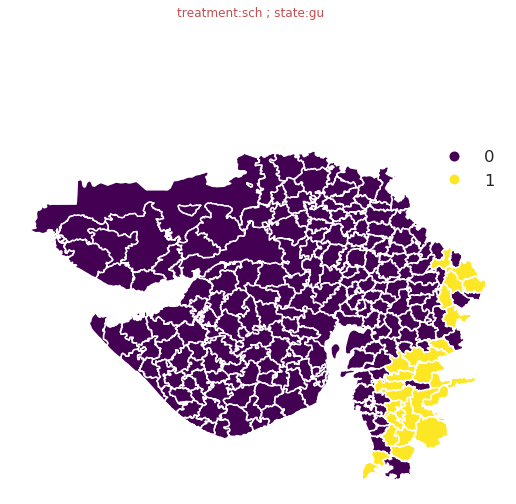

In [39]:
plot_treatment('gu')

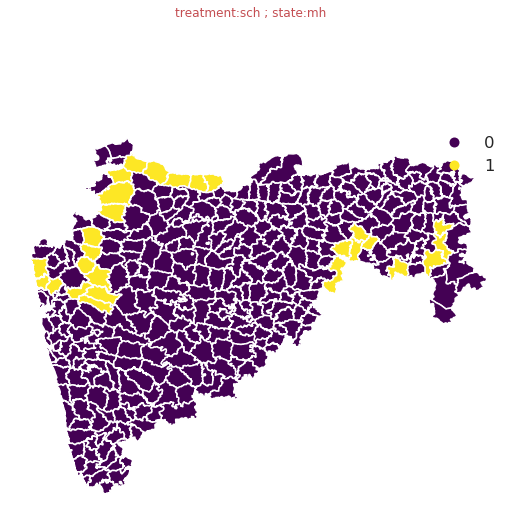

In [40]:
plot_treatment('mh')

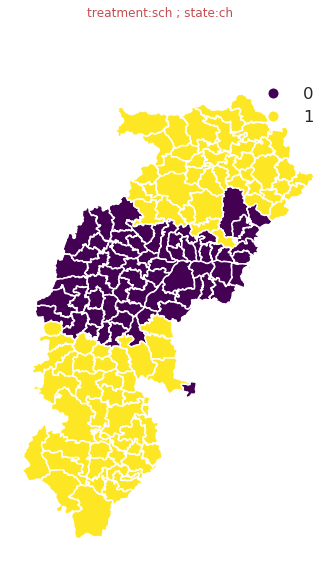

In [41]:
plot_treatment('ch')

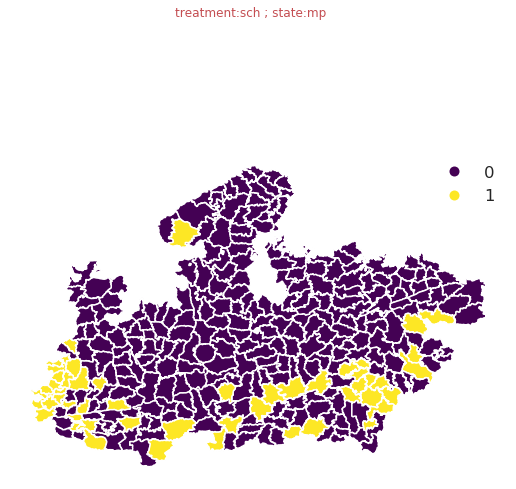

In [42]:
plot_treatment('mp')

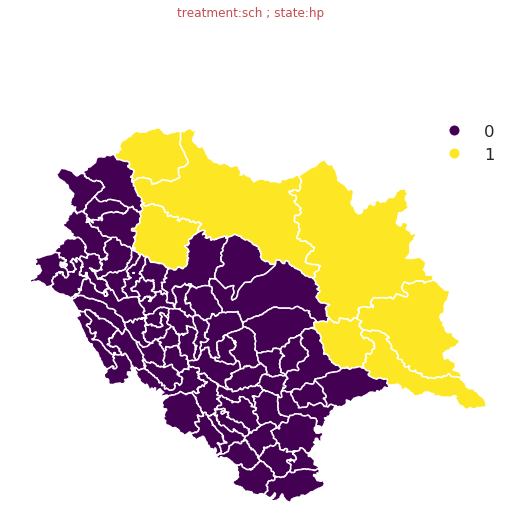

In [43]:
plot_treatment('hp')

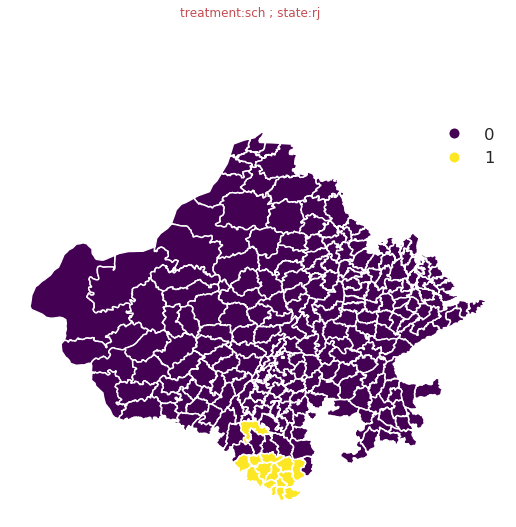

In [44]:
plot_treatment('rj')

In [45]:
treatblocks = block2.loc[block2.sch == 1]
treatblocks.shape
block.C_CODE01.nunique()

(498, 175)

6218

# (IGNORE FOR NEW PREP) Create decimal degree buffers around treated block boundaries
